In [1]:
!gpustat 

gpuserver4  Sun May 26 14:39:33 2019
[0] GeForce GTX 1080 Ti | 61'C,   7 % | 11171 / 11178 MB | chenshouyu(11161M)
[1] GeForce GTX 1080 Ti | 66'C,   0 % | 11171 / 11178 MB | chenshouyu(11161M)
[2] GeForce GTX 1080 Ti | 77'C,   1 % | 10611 / 11178 MB | chenshouyu(10601M)
[3] GeForce GTX 1080 Ti | 35'C,   0 % |    10 / 11178 MB |
[4] GeForce GTX 1080 Ti | 37'C,   0 % |    10 / 11178 MB |
[5] GeForce GTX 1080 Ti | 36'C,   0 % |  1253 / 11178 MB | zbc(1243M)
[6] GeForce GTX 1080 Ti | 75'C,  25 % | 11171 / 11178 MB | chenshouyu(11161M)
[7] GeForce GTX 1080 Ti | 69'C,   0 % | 11171 / 11178 MB | chenshouyu(11161M)
[8] GeForce GTX 1080 Ti | 70'C,   0 % | 10611 / 11178 MB | chenshouyu(10601M)
[9] GeForce GTX 1080 Ti | 48'C,   0 % |   615 / 11178 MB | zbc(605M)


In [2]:
%env CUDA_VISIBLE_DEVICES 3

env: CUDA_VISIBLE_DEVICES=3


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import copy
import tqdm
from PIL import Image

%matplotlib inline

In [4]:
train_dir = 'dogs-vs-cats/train'
test_dir = 'dogs-vs-cats/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [5]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]
        
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ColorJitter(),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(128),
    transforms.ToTensor()
])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transform)

catdogs = ConcatDataset([cats, dogs])

In [6]:
dataloader = DataLoader(catdogs, batch_size = 32, shuffle=True, num_workers=4)

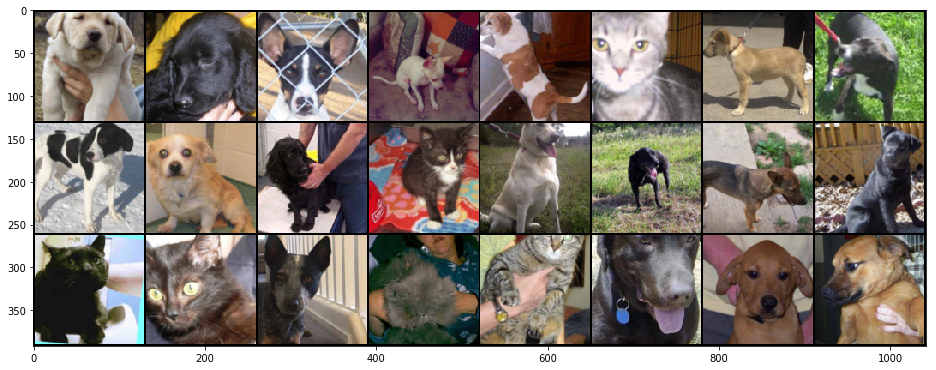

In [7]:
samples, labels = iter(dataloader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch)
# in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [8]:
# transfer learning
device = 'cuda'
model = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/432/zbc/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:06<00:00, 6909336.23it/s]


In [9]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002, amsgrad=True)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500,1000,1500], gamma=0.5)

[Epoch 1/1] Iteration 200 -> Train Loss: 0.5417, Accuracy: 0.875
[Epoch 1/1] Iteration 400 -> Train Loss: 0.3211, Accuracy: 0.875
[Epoch 1/1] Iteration 600 -> Train Loss: 0.2602, Accuracy: 0.906


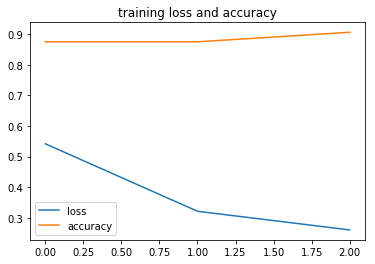

In [10]:
epochs = 1
itr = 1
p_itr = 200
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(epochs):
    for samples, labels in dataloader:
        samples, labels = samples.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        scheduler.step()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(
                epoch+1, epochs, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()

In [11]:
import grad_cam

In [12]:
grad_cam.resnet = copy.deepcopy(model)
del model.fc

In [13]:
grad_cam.resnet(torch.Tensor(1, 3, 224, 224).cuda())[0][0]

tensor(0.4109, device='cuda:0', grad_fn=<SelectBackward>)

In [22]:
grad_cam1 = grad_cam.GradCam(model, ['layer4'], use_cuda=True)
img = cv2.imread('dog.9743.jpg', 1)
img = np.float32(cv2.resize(img, (224, 224))) / 255.
input = grad_cam.preprocess_image(img)
target_index = None
mask = grad_cam1(input, target_index)
grad_cam.show_cam_on_image(img, mask, 'dog_1.png')